# Effects of recursivity and autocorrelated noise in timeseries analysis

This notebook simulates data to understand the effects of recursivity and autocorrelated noise on estimating parameters in timeseries analyses.

Recursivity is defined as the extent to which each time point in the timeseries **data** depends on previous timepoints.  

Autocorrelated noise is the extent to which the residuals/**error** from the predictions of a linear model depend on residuals from previous time points. This violates the assumption of normally distributed IID errors in the linear regression framework.  

In this notebook we generate data that mimmicks the time course of a single voxel in response to a block design task. Two parameters control the amount of recursivity in the data and autocorrelation in the residuals. We recover the recursivity parameter on simulated data both with and without accounting for autocorrelated noise. The "task regressor" coefficient is defined with respect to the recursivity parameter so this exercise gives us an idea of the impact of not accounting for autocorrelated noise in GLMs with real data.  

First we set up our environment.

In [1]:
import copy
import sys
sys.path.append('../utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

Our task is a block design that goes on for 500 ms and comes on for 10 ms every 15 ms after the first block at 11 ms. In total there are 20 events/blocks. Below is the first 100 ms.

(0, 100)

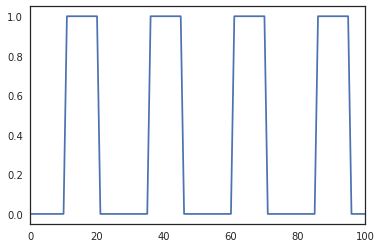

In [2]:
T = np.arange(0,500,1)
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%25>10 and t%25<21:
        tasktiming[0,t] = 1.0
plt.plot(T, tasktiming[0])
#plt.ylim(top = 1.2, bottom = -0.1)
plt.xlim(0,100)

We define the data generating process in `make_y` as:

\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \epsilon(t)
\end{equation*}

where $\phi$ is the recursivity parameter determining the effect of the previous time point on the current time point.  

$x(t)$ is the task regressor where its effect on the data/timeseries is linked (for exercise purposes, albeit unrealistically for real data) to the recursivity parameter.  

$\epsilon$ is the autocorrelated error defined as 

\begin{equation*}
\epsilon(t) = \rho \epsilon(t-1) + v(t)
\end{equation*}

where $\rho$ determines the degree to which the error term from the previous time point affects the error terms in the current time point. $v(t)$ is IID and in line with regression assumptions.

## Accounting for autocorrelated noise

This is done by eliminating the effect of $\epsilon$ in the estimation of $\phi$. We start by substituting the error term in the original equation 

\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \rho \epsilon(t-1) + v(t)
\end{equation*}

where

\begin{equation*}
\epsilon(t-1) = y(t-1) - \phi y(t-2) - (1-\phi)x(t-1)
\end{equation*}

so to remove $\epsilon$ from the estimation of $y(t)$ where the only error terms left the IID $v(t)$ we rewrite the equation as:  

\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \rho (y(t-1) - \phi y(t-2) - (1-\phi)x(t-1)) + v(t)
\end{equation*}

which can be rearranged as:  
\begin{equation*}
y(t) = \phi y(t-1) + (1-\phi)x(t) + \rho y(t-1) - \rho\phi y(t-2) - \rho(1-\phi)x(t-1) + v(t)  
\end{equation*}


\begin{equation*}
y(t) = (\phi+\rho) y(t-1)  - \rho\phi y(t-2) + (1-\phi)x(t) - \rho(1-\phi)x(t-1) + v(t)
\end{equation*}

where $\beta_3 = (1-\phi)$ would yield a un-/less biased estimate of $\phi$

Note: The other coefficients from this model could/should also yield better estimates of $\phi$ but since we don't know the true $\rho$ in the estimation step (as opposed to the simulation step) and instead estimate it as $\hat{\rho}$ using the residuals from the uncorrected model using the other coefficients to estimate a corrected $\phi$ would depend on the how well $\hat{\rho}$ is estimated.


## Prewhitening

Translating the steps in [this blog post by Mandy Mejia](https://mandymejia.com/2016/11/06/how-to-efficiently-prewhiten-fmri-timeseries-the-right-way/) to estimate a voxelwise prewhitening matrix and rerun regression

### Run GLM without prewhitening



In [3]:
def make_y(x, phi, rho, mu=0, sigma=1):
    y = y = np.zeros(len(x))
    
    noise = np.random.normal(mu, sigma, len(y))
    
    for i in range(len(y)):
        if i == 0:
            y[i] = copy.copy(x[i])
        else:
            noise[i] = rho*noise[i-1]+noise[i]
            y[i] = phi*y[i-1]+(1-phi)*x[i]+noise[i]
            
    return(y)

In [4]:
eg_x = copy.copy(tasktiming[0])
eg_y = make_y(eg_x, .5, .7)

eg_X = eg_x.reshape(-1,1)
## Constant/GLM:
#X = sm.add_constant(X)
eg_y_lag = np.r_[0, eg_y[:-1]]
eg_y_lag = eg_y_lag.reshape(-1,1)
eg_X = np.concatenate((eg_X, eg_y_lag), 1)

#No intercept model
eg_mod = sm.OLS(eg_y, eg_X)
eg_res = eg_mod.fit()
eg_est_phi = eg_res.params[1]

### Run AR(p) on residuals of GLM



In [5]:
eg_errors = eg_res.resid
#Running AR(1) since that is the data generating process
#eg_mod1 = ARMA(eg_errors, order=(1,0))
eg_mod1 = sm.tsa.SARIMAX(eg_errors, order=(1,0,0))
eg_res1 = eg_mod1.fit()

Does the ARMA function work right? Do I get the same values in the example in [here](https://newonlinecourses.science.psu.edu/stat510/lesson/8/8.1)

### Calculate A using p coefficients



In [6]:
eg_first_col = np.insert(-eg_res1.params[:-1], 0, 1)
eg_first_col

array([ 1.        , -0.38738694])

In [7]:
for i in range(len(eg_y)-1):
    if i == 0:
        eg_cur_col = copy.copy(eg_first_col)
        eg_cur_col = np.insert(eg_cur_col, 2, np.zeros(len(eg_y)-len(eg_res1.params)))
        eg_A = eg_cur_col.reshape(-1,1)
    else:
        eg_cur_col = eg_A[:,i]
    eg_col_lag = np.r_[0, eg_cur_col[:-1]]
    eg_col_lag = eg_col_lag.reshape(-1,1)
    eg_A = np.concatenate((eg_A, eg_col_lag), 1)

In [8]:
eg_A[:5,:5]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.38738694,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.38738694,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.38738694,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.38738694,  1.        ]])

### Calculate $V^{-1}$


In [9]:
eg_V_inv = np.dot(eg_A, eg_A.T)

In [10]:
eg_V_inv[:5,:5]

array([[ 1.        , -0.38738694,  0.        ,  0.        ,  0.        ],
       [-0.38738694,  1.15006864, -0.38738694,  0.        ,  0.        ],
       [ 0.        , -0.38738694,  1.15006864, -0.38738694,  0.        ],
       [ 0.        ,  0.        , -0.38738694,  1.15006864, -0.38738694],
       [ 0.        ,  0.        ,  0.        , -0.38738694,  1.15006864]])

### Calculate W


In [11]:
eg_u, eg_d, eg_vh = np.linalg.svd(eg_V_inv)

In [12]:
eg_W=eg_u.dot(np.sqrt(np.diag(eg_d))).dot(eg_u.T)
eg_W.shape

(500, 500)

In [13]:
eg_W[:5,:5]

array([[ 9.80871856e-01, -1.93730336e-01, -1.85864202e-02,
        -3.56533919e-03, -8.56433929e-04],
       [-1.93730336e-01,  1.03733404e+00, -1.90095539e-01,
        -1.80616883e-02, -3.46435008e-03],
       [-1.85864202e-02, -1.90095539e-01,  1.03785877e+00,
        -1.89994550e-01, -1.80389992e-02],
       [-3.56533919e-03, -1.80616883e-02, -1.89994550e-01,
         1.03788146e+00, -1.89988928e-01],
       [-8.56433929e-04, -3.46435008e-03, -1.80389992e-02,
        -1.89988928e-01,  1.03788295e+00]])


### Run prewhitened GLM

In [14]:
eg_Wy = np.dot(eg_W,eg_y)
eg_Wy.shape

(500,)

In [15]:
eg_WX = np.dot(eg_W,eg_X)
eg_WX.shape

(500, 2)

In [16]:
eg_mod_cr = sm.OLS(eg_Wy, eg_WX)
eg_res_cr = eg_mod_cr.fit()
eg_est_phi_cr = eg_res_cr.params[1]

In [17]:
print("True value: %s\nEstimated value pre correction: %s\nEstimated value post correction: %s"%(.5,round(eg_est_phi,3), round(eg_est_phi_cr, 3)))

True value: 0.5
Estimated value pre correction: 0.877
Estimated value post correction: 0.771


Note that these operations are equivalent to the vectorized versions below as described [here](https://newonlinecourses.science.psu.edu/stat510/lesson/8/8.1)

```
arp = eg_res1.params[1]

new_y = eg_y-(np.r_[0, eg_y[:-1]]*arp)

eg_X_lag = np.roll(eg_X, 1, axis=0)
eg_X_lag[0,:] = np.array([0,0])
new_X = eg_X - arp*eg_X_lag

new_eg_mod = sm.OLS(new_y, new_X)
new_eg_res = new_eg_mod.fit()
new_eg_est_phi = new_eg_res.params[1]
```

## Simulations

### Helper functions

In [18]:
def whiten(mod_obj, p=1, q=0, verbose=False):
    
    err = mod_obj.fit().resid
    X = mod_obj.exog
    y = mod_obj.endog
    
    try:
        #ar_mod = ARMA(err, order=(p,0))
        ar_mod = sm.tsa.SARIMAX(err, order=(p,q,0))
        ar_res = ar_mod.fit()
        #first_col = np.insert(-ar_res.params[1:], 0, 1)
        first_col = np.insert(-ar_res.params[:-1], 0, 1)
        for i in range(len(y)-1):
            if i == 0:
                cur_col = copy.copy(first_col)
                cur_col = np.insert(cur_col, 2, np.zeros(len(y)-len(ar_res.params)))
                A = cur_col.reshape(-1,1)
            else:
                cur_col = A[:,i]
            col_lag = np.r_[0, cur_col[:-1]]
            col_lag = col_lag.reshape(-1,1)
            A = np.concatenate((A, col_lag), 1)
        
        V_inv = np.dot(A,A.T)
        
        u, d, vh = np.linalg.svd(V_inv)
        
        W=u.dot(np.sqrt(np.diag(d))).dot(u.T)
        
        Wy = np.dot(W,y)
        WX = np.dot(W,X)
        
        mod_pw = sm.OLS(Wy, WX)
        res_pw = mod_pw.fit()
        
        out = res_pw.params
        
        if verbose:
            print(V_inv[:5, :5])
        
    except:
        print("Whitening failed!")
        out = [np.nan, np.nan]
    return(out)

In [19]:
#whiten(eg_mod)

Function to recover the $\phi$ and $\rho$ parameters from either given data or after simulating data.  

Arguments:

`phi_stim`: $\phi$ that will be used if simulating data.  
`rho_stim`: $\rho$ that will be used if simulating data.  
`x`: Simulate task data if None; numpy array with task timeseries otherwise.  
`y`: Simulate task data if none; numpy array with response timeseries otherwise.  
`Tmax`: Number of timepoints to simulate data for.  
`mu_stim`: Mean of error term.  
`sigma_stim`: SD of error term.  
`verbose`: Print true and estimated parameter estimates while running.  
`ar_correction`: Return recursivity parameter after accounting for autocorrelated noise.  

Output:

Dictionary with simulation and estimation parameters  

In [20]:
def get_phi_rho(phi_stim, rho_stim, x=None, y=None, Tmax = 500, mu_stim=0, sigma_stim=1, verbose = True, ar_correction = True, prewhiten=True, arp=1):
    
    if x is None:
        T = np.arange(0,Tmax,1)
        tasktiming = np.zeros((1,len(T)))
        for t in range(len(T)):
            if t%25>10 and t%25<21:
                tasktiming[0,t] = 1.0
        x = copy.copy(tasktiming[0])
    
    if y is None:
        y = make_y(x, rho=rho_stim, phi = phi_stim)
    
    X = x.reshape(-1,1)
    ## Constant/GLM:
    #X = sm.add_constant(X)
    y_lag = np.r_[0, y[:-1]]
    y_lag = y_lag.reshape(-1,1)
    X = np.concatenate((X, y_lag), 1)

    #No intercept model
    mod = sm.OLS(y, X)
    res = mod.fit()
    est_phi = res.params[1]
    
    errors = res.resid

    errors_lag = np.r_[0, errors[:-1]]
    errors_X = errors_lag.reshape(-1,1)

    #No intercept model
    error_mod = sm.OLS(errors, errors_X)
    error_res = error_mod.fit()
    est_rho = error_res.params[0]
    
    if verbose:
        print("Actual phi = %s; estimated phi = %s"%(phi_stim,str(round(est_phi, 5))))
        print("Actual rho = %s; estimated rho = %s"%(rho_stim, str(round(est_rho, 5))))
    
    out = {"phi_stim": phi_stim,
          'rho_stim': rho_stim,
          'phi_est': est_phi,
          'rho_est': est_rho}
    
    if ar_correction:
        arc_X = copy.copy(y_lag)
        y_lag2 = np.r_[0, np.r_[0, y[:-1]][:-1]]
        y_lag2 = y_lag2.reshape(-1,1)
        arc_X = np.concatenate((arc_X, y_lag2), 1)
        arc_X = np.concatenate((arc_X, x.reshape(-1,1)), 1)
        x_lag = np.r_[0, x[:-1]]
        x_lag = x_lag.reshape(-1,1)
        arc_X = np.concatenate((arc_X, x_lag), 1)
    
        arc_mod = sm.OLS(y, arc_X)
        arc_res = arc_mod.fit()
        
        est_phi_arc = 1 - arc_res.params[2]
        
        out.update({"phi_est_arc": est_phi_arc})
        
        if verbose:
            print("Actual phi = %s; estimated phi with arc = %s"%(phi_stim,str(round(est_phi_arc, 5))))
            
    if prewhiten:
        pw_params = whiten(mod_obj=mod, p=arp, q=0, verbose=verbose)
        
        out.update({"phi_est_pw": pw_params[1]})
        
        if verbose:
            print("Actual phi = %s; estimated phi with pw = %s"%(phi_stim,str(round(pw_params[1], 5))))
        
    return(out)

In [21]:
get_phi_rho(.5, .5)

Actual phi = 0.5; estimated phi = 0.78384
Actual rho = 0.5; estimated rho = 0.1685
Actual phi = 0.5; estimated phi with arc = 0.689
[[ 1.         -0.96440042  0.          0.          0.        ]
 [-0.96440042  1.93006818 -0.96440042  0.          0.        ]
 [ 0.         -0.96440042  1.93006818 -0.96440042  0.        ]
 [ 0.          0.         -0.96440042  1.93006818 -0.96440042]
 [ 0.          0.          0.         -0.96440042  1.93006818]]
Actual phi = 0.5; estimated phi with pw = 0.09326


{'phi_est': 0.7838373844953861,
 'phi_est_arc': 0.6889964088329767,
 'phi_est_pw': 0.09325520122929218,
 'phi_stim': 0.5,
 'rho_est': 0.16850366718591755,
 'rho_stim': 0.5}

In [22]:
get_phi_rho(.6, .8)

Actual phi = 0.6; estimated phi = 0.94227
Actual rho = 0.8; estimated rho = 0.4859
Actual phi = 0.6; estimated phi with arc = 0.61409
[[ 1.         -1.15660028  0.          0.          0.        ]
 [-1.15660028  2.33772421 -1.15660028  0.          0.        ]
 [ 0.         -1.15660028  2.33772421 -1.15660028  0.        ]
 [ 0.          0.         -1.15660028  2.33772421 -1.15660028]
 [ 0.          0.          0.         -1.15660028  2.33772421]]
Actual phi = 0.6; estimated phi with pw = 0.55607


{'phi_est': 0.9422721817959178,
 'phi_est_arc': 0.6140933507589937,
 'phi_est_pw': 0.5560706767117041,
 'phi_stim': 0.6,
 'rho_est': 0.4858985470355234,
 'rho_stim': 0.8}

### Simulation results

For $\phi$ and $\rho$ ranging from 0 to 1 with .1 increments simulate recursive data with autocorrelated noise and estimate the recursivity parameter using ordinary least squares with and without accounting for the autocorrelation.

In [23]:
phi_stims=np.arange(0,1.1,.1)
rho_stims=np.arange(0,1.1,.1)

out = {}

for p in phi_stims:
    for r in rho_stims:
        sim_id = "phi_%s_rho_%s"%(p, r)
        out[sim_id] = get_phi_rho(p, r, verbose=False)

Organize output

In [24]:
out_df = pd.DataFrame(out).T
out_df['phi_stim'] = round(out_df['phi_stim'],1)
out_df['rho_stim'] = round(out_df['rho_stim'],1)

In [25]:
out_df.reset_index(drop=True,inplace=True)

Calculate the degree to which estimated parameters deviate from the true variable used in the simulation

\begin{equation*}
deviation = |estimate - truth|
\end{equation*}

In [26]:
out_df['phi_pct_diff'] = abs(out_df['phi_est'] - out_df['phi_stim'])
out_df['phi_pct_diff_arc'] = abs(out_df['phi_est_arc'] - out_df['phi_stim'])
out_df['phi_pct_diff_pw'] = abs(out_df['phi_est_pw'] - out_df['phi_stim'])
out_df['rho_pct_diff'] = abs(out_df['rho_est'] - out_df['rho_stim'])
#out_df['phi_improvement'] = (out_df['phi_pct_diff'] - out_df['phi_pct_diff_arc'])*(-1)

Darker colors are larger deviations from truth ("bad")

Largest improvements in estimating $\phi$ are when $\rho$ is large too (>0.3) **regardless** of how good the $\hat{\rho}$ is.

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


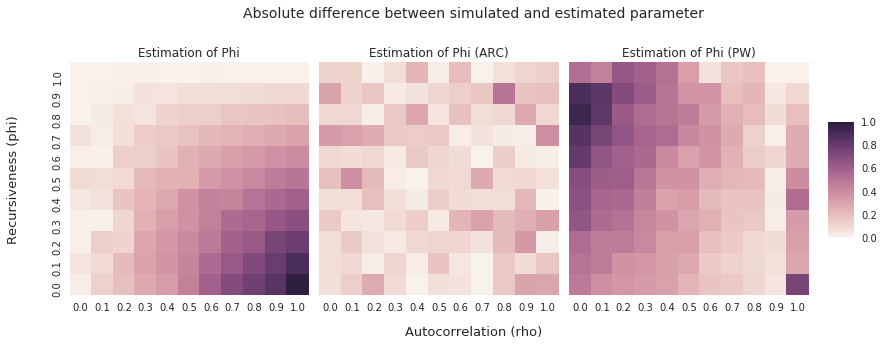

In [28]:
plt.rcParams["figure.figsize"][0] = 12
plt.rcParams["figure.figsize"][1] = 4
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
vals = ['phi_pct_diff','phi_pct_diff_arc','phi_pct_diff_pw']
ax_titles = ['Estimation of Phi','Estimation of Phi (ARC)', 'Estimation of Phi (PW)']
for i, ax in enumerate(axn.flat):
    df = out_df.pivot(index='phi_stim',columns='rho_stim',values='%s'%(vals[i]))
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                xticklabels=True, yticklabels=True,
                cbar_ax=None if i else cbar_ax)
    ax.set_title('%s'%(ax_titles[i]))
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.invert_yaxis()

fig.suptitle("Absolute difference between simulated and estimated parameter", fontsize=14, y = 1.1)
fig.text(-0.04, 0.5, 'Recursiveness (phi)', va='center', rotation='vertical', size=13)
fig.text(0.5, -0.04, 'Autocorrelation (rho)', ha='center', size = 13)
fig.tight_layout(rect=[0, 0, .9, 1])


## Additional concerns with timeseries analyses



### Direct test of stationarity: Unit test

If |$\phi|<1$ AR(1) process is stationary (where phi is the parameter that determines the relationship between $y(t)$ and $y(t+1))$

When $\phi$ is not known (ie. not simulated data) you can use the first derivative of the timeseries to check if the slope is negative (if yes, then stationary).


#### Why is stationarity important?   
- because a regression between two nonstationary variables can produce spurious results (e.g. regressing the time series of one voxel over the time series of a task, of another voxel etc.)  

#### How do you make a time series stationary?  
- by taking the derivative until $|\phi|<1$ 

### Indirect test of stationarity: Correlogram and autocorrelation

In [ ]:
def make_correlogram(y, max_lag):
    for i in range(2,max_lag):
        #y_lag = np.roll(y, -i)
        y_lag = np.roll(y, i)
        #y_lag = y_lag[:-i]
        y_lag[:i] = 0
        y_cur = y[:len(y_lag)]
        ac = (np.cov(y_cur, y_lag)[0][1]) / (np.var(y_cur))
        print("s = %s, AC = %s"%(str(i), str(ac)))

When the time series are **not** stationary the autocorrelation does **not** decline quickly.  

Note: As explained below only $\phi$=1 is the time series we generate are not stationary.

In [ ]:
x = copy.copy(tasktiming[0])
y = make_y(x, 1, 0)
make_correlogram(y, 10)

In [ ]:
y = make_y(x, .1, 0.5)
make_correlogram(y, 10)

In [ ]:
y = make_y(x, .8, 0.5)
make_correlogram(y, 10)

In [ ]:
import requests

In [ ]:
response = requests.get('https://newonlinecourses.science.psu.edu/stat510/sites/stat510/files/data/econpredictor_1.dat')

In [ ]:
data_decoded = response.content.decode("UTF-8")
data_decoded = data_decoded.replace("\n", " ")
data = [float(i) for i in data_decoded.split(' ')[:-1]] 

In [ ]:
response = requests.get('https://newonlinecourses.science.psu.edu/stat510/sites/stat510/files/data/econmeasure_0.dat')

In [ ]:
y_decoded = response.content.decode("UTF-8")
y_decoded = y_decoded.replace("\n", " ")
y = [float(i) for i in y_decoded.split(' ')[:-1]] 

In [ ]:
data = np.array(data).reshape(-1,1)
data = sm.add_constant(data)
y = np.array(y)
a_mod = sm.OLS(y, data)

In [ ]:
a_res = a_mod.fit()

In [ ]:
a_res.summary() #replicates r output

In [ ]:
#b_mod = ARMA(a_res.resid, order=(1,0))
b_mod = sm.tsa.SARIMAX(a_res.resid, order=(2,0,0))
b_res = b_mod.fit()

In [ ]:
b_res.summary() 

In [ ]:
b_res.params[:-1]